In [1]:
# https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

In [1]:
import os
import pandas as pd
import numpy as np
import glob 
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from PIL import Image
from IPython import display 

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Exploration

## Exploration du dataset

In [3]:
label = pd.read_csv("labels.csv")

C:\Anaconda501\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


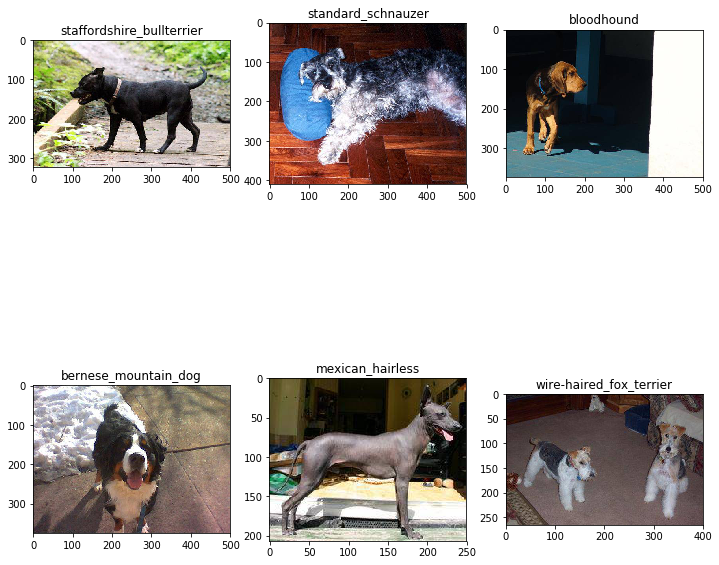

In [4]:
elems = label.ix[random.sample(range(len(label)), 6)][['id', "breed"]].values

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join("train/", elems[i][0] + ".jpg")
    pil_im = Image.open(url)
    name = elems[i][1]
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
    axarr[line, column].set_title(name)
plt.show()

In [5]:
label.groupby("breed").agg({"id" : "count"})["id"].describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: id, dtype: float64

On a entre 66 et 126 images pour chaque classes. C'est donc un dataset a peu près balanced

## Paramètres des images

### Récupération des données

Pour faire l'analyse de certaines données, on va extraire celle ci et les stocker dans un dataset

In [84]:
# img = []
# height_list = []
# width_list = []

# for filename in glob.glob('test/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)

# for filename in glob.glob('train/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)
    
# for filename in glob.glob('train/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)

# df = pd.DataFrame({"Image" : img, "Height" : height_list, "Width" : width_list})

# df.to_csv("img_format.csv")

### Taille des images

On peut regarder la taille des images. Cela aidera dans le cas ou l'on doit redimensionner

In [6]:
df= pd.read_csv("img_format.csv", index_col=0)

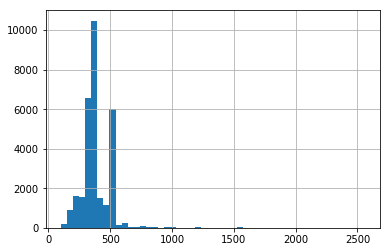

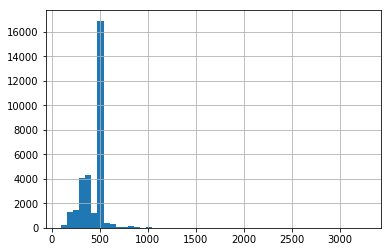

In [7]:
df["Height"].hist(bins=50)
plt.show()

df["Width"].hist(bins=50)
plt.show()

### Nombre de Pixels

De même on peut regarder au niveau du nb de pixels car on peut avoir une image très large mais avec peu de pixel si sa hauteur est faible

In [8]:
df["Pixels"] = df["Height"]*df["Width"]

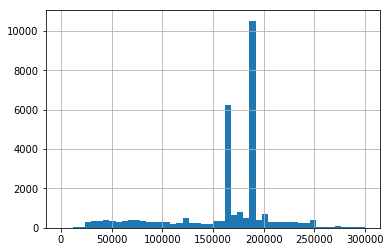

In [9]:
df["Pixels"].hist(bins=50, range = (0, 300000))
plt.show()

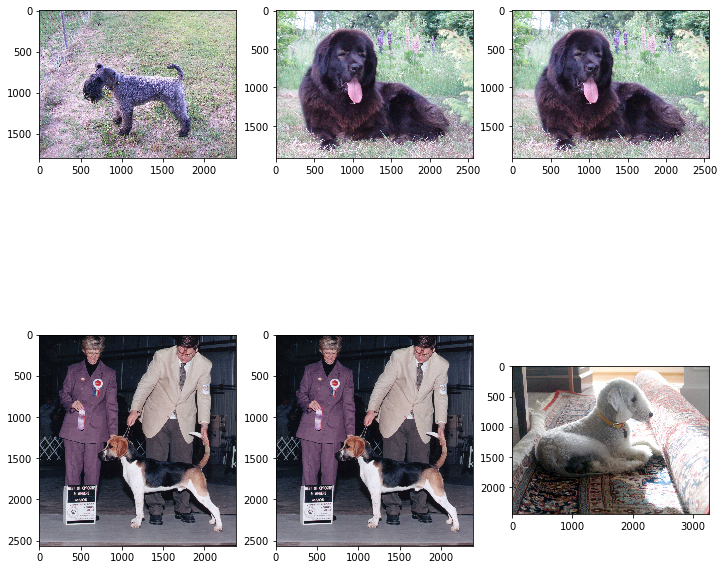

In [11]:
sublabel = df[df["Pixels"] > 4e6]
elems = sublabel.iloc[random.sample(range(len(sublabel)), 6)]["Image"].values
elems[1]

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join(elems[i])
    pil_im = Image.open(url)
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
plt.show()

### Ratio W/H

Comme on va scaler les images avant d'entrainer le reseau, il faudrait regarder les images avec un fort Ratio W/H. En redimensionnant, on va écraser les features et rendre l'entrainement moins bon. On va donc redimensionner certaines images avec un ration trop grand/petit

In [121]:
df["Ratio"] = df["Height"]/df["Width"]

In [126]:
len(df[(df["Ratio"] > 2) | (df["Ratio"] < 0.5)])

67

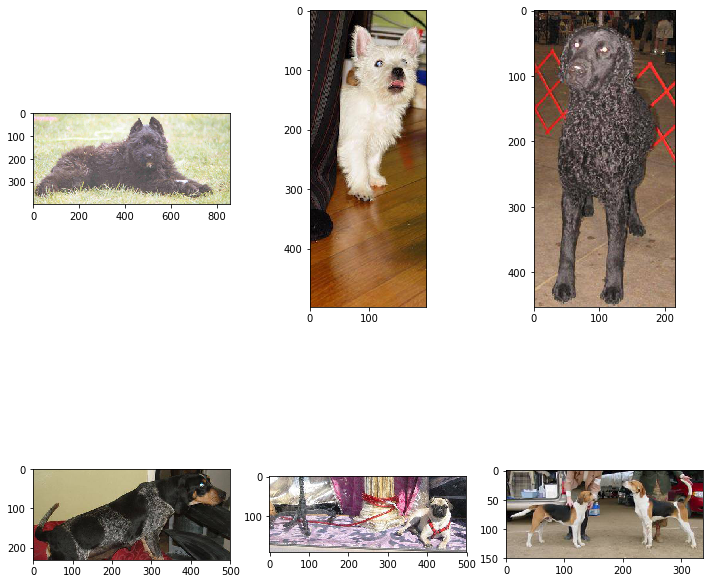

In [125]:
sublabel = df[(df["Ratio"] > 2) | (df["Ratio"] < 0.5)]
elems = sublabel.iloc[random.sample(range(len(sublabel)), 6)]["Image"].values
elems[1]

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join(elems[i])
    pil_im = Image.open(url)
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
plt.show()

### Image à retravailler

Avant de passer au modèle, on va retoucher quelques images à la main. Etant donnée que l'on a pas de Région Boundaries fourni avec le dataset, il est difficile de réduire automatiquement l'image à un ratio voulu

Les images ayant beaucoup de pixels étant plutot avec un faible ratio W/H, on ne va retravailler que les images de training ayant un fort/faible ratio W/H. L'objectif étant d'éviter que le modèle n'apprenent des features inutiles ou que le rescale en preprocessing écrase trop les features

In [159]:
len(df[((df["Ratio"] > 1.8) | (df["Ratio"] < 0.5)) & (df["Image"].str.contains("train")) ]["Image"])

74

In [160]:
rework = df[((df["Ratio"] > 1.8) | (df["Ratio"] < 0.5)) & (df["Image"].str.contains("train")) ]["Image"]

In [161]:
for image in rework.values:
    try:
        name = os.path.basename(image)
        os.rename(os.path.join("train", name), os.path.join("train", "rework", name))
    except:
        pass

Les images dans le dossier rework ont donc été coupé a la main pour garder une zone a peu près carré logique et car il y en avait pas beaucoup (env 30). Dans d'autres situations, il faudrait peut-etre mettre en place un algo qui reduit la région ou est le chien (region proposal network)

### Redimensionnement

Les tailles d'inputs sont réglementés pour les pre-trained NN comme suit :

<ul>
<li>(299, 299, 3) : Xception</li>
<li>(224, 224, 3) : VGG16 / VGG19</li>
<li>(224, 224, 3) : ResNet50</li>
<li>(299, 299, 3) : InceptionV3</li>
<li>(299, 299, 3) : InceptionResNetV2</li>
<li>(224, 224, 3) : MobileNet</li>
</ul>

De ce fait, on va commencer par redimensionner toutes les images en 299x299. Deja cela permettra au moyen classique d'avoir le meme nb de pixels dans chaques images et le redimensionnement pour les pre-trained NN seront necessaire que pour les passer en 224x244 si necessaire

In [25]:
# for filename in glob.glob('test/*.jpg'):
#     img = Image.open(filename)
#     img = img.resize((299, 299), Image.ANTIALIAS)
#     img.save(os.path.join("test/resized/", os.path.basename(filename)))
    
# for filename in glob.glob('train/*.jpg'):
#     img = Image.open(filename)
#     img = img.resize((299, 299), Image.ANTIALIAS)
#     img.save(os.path.join("train/resized/", os.path.basename(filename)))

### Augmentation manuelle

Avant de faire les features extraction, une tentative d'augmentation a été faite. L'idée était de créer le double d'images en utilisant un flip vertical. En effet, ce flip simule la vision en mirroir et permet donc au réseau en théorie de mieux apprendre.

In [60]:
# a = label["id"].tolist()
# b = [x[::-1] for x in a]
# print(set(a) & set(b))

set()


In [72]:
# for filename in glob.glob('train/resized/*.jpg'):
#     name_img = os.path.basename(filename)[:-4]
#     path = os.path.dirname(filename)
#     img = Image.open(filename)
#     out = img.transpose(Image.FLIP_LEFT_RIGHT)
#     out.save(os.path.join(path, name_img[::-1]+".jpg"))

In [74]:
# label = pd.read_csv("labels.csv")
# label_2 = label.copy()

In [80]:
# label_2["id"] = label_2["id"].str[::-1]

In [82]:
# result = pd.concat([label, label_2])

In [84]:
# result.to_csv("label_augmented.csv")

In [3]:
# label = pd.read_csv("label_augmented.csv", index_col=0)

#### Retour en arrière

Avec cette augmentation, on a un fort overfitting. En effet, avec la cross-validation, on va evaaluer potentiellement des mirroir d'images d'entrainements. De ce fait, on va les retirer

In [6]:
l_id = label["id"].tolist()
for filename in glob.glob('train/resized/*.jpg'):
    name_img = os.path.basename(filename)[:-4]
    if name_img not in l_id:
        os.rename(filename, "train/mirror/" + name_img+"jpg")